In [79]:
import os

if not os.getcwd().endswith('Dissertation'):
    os.chdir('..')

In [80]:
import pandas as pd
from utils import convert_timespan_str_to_float

unfiltered_data = pd.read_csv('Data\\Updated_CSV_data\\2020.csv')
filtered_data = pd.read_csv('Data\\Updated_CSV_data_Filtered\\2020.csv')


date = '08_09'
unfiltered_data = unfiltered_data[(unfiltered_data['Date'] == date) &
                                  (unfiltered_data['SessionName'].isin(['Q1', 'Q2', 'Q3'])) &
                                  (unfiltered_data['IsOutLap'] == False) &
                                  (unfiltered_data['IsInLap'] == False)].reset_index(drop=True)

filtered_data = filtered_data[filtered_data['Date'] == date].reset_index(drop=True)

unfiltered_data['LapTime'] = unfiltered_data['LapTime'].apply(convert_timespan_str_to_float)
unfiltered_data['ExpectedTime'] = unfiltered_data['ExpectedTime'].apply(convert_timespan_str_to_float)

unfiltered_data.to_csv('Data\\temp.csv')

unfiltered_cutoff = [34, 66, 87]
filtered_cutoff = [24, 55, 74]

lewis_row = filtered_data.copy().iloc[75:76]

In [81]:
import random

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel

from src.ModelUsage import convert_to_training_data, convert_to_input
from src.ModelUsage import get_trained_model, random_search


def train_and_predict(choice, session, row):
    index = int(session[1])-1
    if choice == 'filtered':
        data_to_use = filtered_data.copy()
        data_cutoff = filtered_cutoff[index]
        file_path = 'Data\\Updated_CSV_data_Filtered\\2020.csv'
    else:
        data_to_use = unfiltered_data.copy()
        data_cutoff = unfiltered_cutoff[index]
        file_path = 'Data\\temp.csv'

    data_to_use = data_to_use[:data_cutoff]
    indices = data_to_use.index[data_to_use['Date'] == date].tolist()

    X_kernel = random.sample(indices, len(indices) // 2)

    dataframe = data_to_use.copy()

    dataframe, X_kernel = dataframe.drop(index=X_kernel), dataframe.loc[X_kernel]

    X_train_kernel, y_train_kernel = convert_to_training_data(X_kernel)
    X_train, y_train = convert_to_training_data(dataframe)

    kernel = RBF() + RBF() + ConstantKernel()
    new_kernel, loss = random_search(GaussianProcessRegressor, kernel, (1e-10, 1e10),
                                     X_train, y_train, X_train_kernel, y_train_kernel,
                                     size=3, loops=10, return_loss=True, pbar=False)


    model, constants = get_trained_model(new_kernel, file_path, data_cutoff=data_cutoff, return_constants=True)
    mean, std = model.predict(convert_to_input(row, constants), return_std=True)

    return mean, std

In [82]:
expected_time = lewis_row.iloc[0]['ExpectedTime']
lewis_row['LapsCompleted'] = 40
filtered_predictions = dict()
unfiltered_predictions = dict()

for i in ['Q1', 'Q2', 'Q3']:
    lewis_row['SessionName'] = i
    mean, std = train_and_predict('filtered', i, lewis_row)
    filtered_predictions[i] = {'mean': mean + expected_time, 'std': std}

    mean, std = train_and_predict('unfiltered', i, lewis_row)
    unfiltered_predictions[i] = {'mean': mean + expected_time, 'std': std}

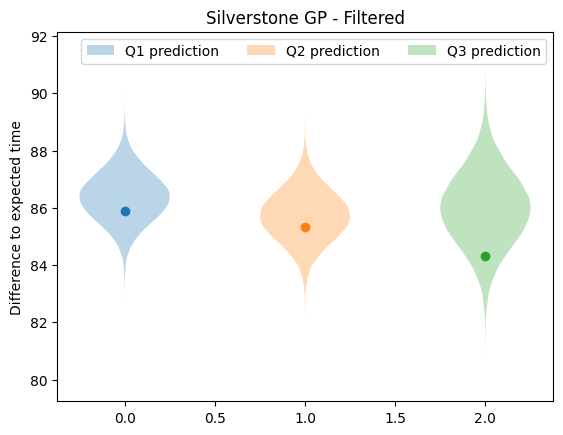

In [95]:
import numpy as np
import matplotlib.pyplot as plt

actual_times = [85.9, 85.347, 84.303]
distributions = []
vp = [0,0,0]
for count, (key, value) in enumerate(filtered_predictions.items()):
    mean = value['mean'][0]
    std = value['std'][0]
    vp[count] = plt.violinplot(np.random.normal(mean, std, 100000), positions=[count], showextrema=False)
    plt.scatter([count], [actual_times[count]])

plt.title('Silverstone GP - Filtered')
plt.ylabel('Difference to expected time')
plt.legend([i['bodies'][0] for i in vp], ['Q1 prediction', 'Q2 prediction', 'Q3 prediction'], ncol=2)
plt.savefig('Data\\Plots\\temp.png')
plt.show()